# Credit Card Fraud Detection

## 1. Abstract

Fraud detection is one of the most popular regions of application of machine learning. Credit card fraud detection is a specific aspect of that.

We have at hand a dataset based on the transactions made by credit cards in September 2013 by European card-holders over 2 days. The dataset is a transformed version of the original data; PCA transformation is done to produce a number of numerical valued features. The target is a binary indicator denoting fraud/no fraud. Our aim is to build a classification model to predict/identify the fraud cases.

The source of this dataset is from <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Kaggle</a>, thanks to Machine Learning Group - ULB (Université Libre de Bruxelles).

## 2. Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, \
GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from scipy.stats import randint, uniform

## 3. Loading the dataset

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 4. Sanity checks

### 4.1 Missing values

In [4]:
data.isnull().any().where(lambda x: x==True).dropna()

Series([], dtype: object)

**Therefore, there are no missing values to handle**.

### 4.2 Data-types

In [5]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Time is a measure of the amount of time since the earliest transaction in the dataset; natural for it to be in float64 form. V1-V28 (the outputs of PCA transformation) and Amount are float64 as per expectation. Class, supposed to be a binary-valued feature is int64. **So all is fine in terms of the data-types as well**.

### 4.3 Time, Amount, Class value specific sanity checks

In [6]:
data['Time'].where(lambda x: x<0).dropna()

Series([], Name: Time, dtype: float64)

In [7]:
data['Amount'].where(lambda x: x<0).dropna()

Series([], Name: Amount, dtype: float64)

In [8]:
data['Class'].value_counts(normalize=True, dropna=False)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Time and Amount are positive as per expectation and Class only contains 0 and 1 (with only 0.173% being the fraud cases). **Hence, Time, Amount and Class meet the value specific expectations**.

### 4.4 Scale of V1 - V28, Amount

In [9]:
data.drop(['Time','Amount','Class'], axis=1).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,...,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01


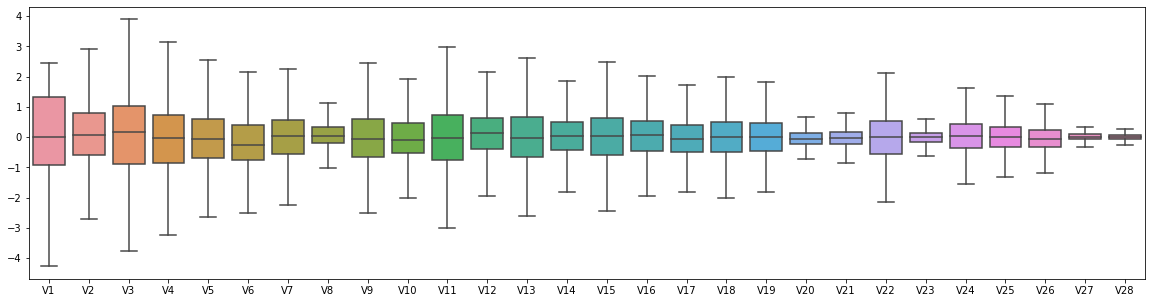

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=data.drop(['Time','Amount','Class'], axis=1), orient='v', showfliers=False, ax=ax);

V1-V28 all have near 0 mean which is expected for properly PCA transformed features.

## 5 Test-train split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class'], axis=1), data['Class'], test_size=0.25, stratify=data['Class'], random_state=42)

## 6. Feature engineering

### 6.1 Scaling Time and Amount

In [6]:
time_amount_scaler = StandardScaler().fit(X_train[['Time','Amount']])

In [7]:
X_train[time_amount_scaler.feature_names_in_] = time_amount_scaler.transform(X_train[time_amount_scaler.feature_names_in_])

In [8]:
X_train[['Time','Amount']].describe()

,Time,Amount
count,2.136050e+05,2.136050e+05
mean,-3.605438e-17,7.081898e-17
std,1.000002e+00,1.000002e+00
min,-1.998112e+00,-3.521314e-01
25%,-8.561119e-01,-3.296184e-01
50%,-2.126131e-01,-2.643147e-01
75%,9.366303e-01,-4.277697e-02
max,1.640352e+00,1.021985e+02


## 7. Experimental model fit

We will try a bunch of models one by one and try to figure out how they perform. Then we will, if necessary, move towards ensembling different models.

In [21]:
# A common cv-split to be used across all model fits and made reproducible so that the splitwise comparison among models
# is justified.

# The inner_cv is used for grid-search and randomized-search hyper-parameter tuning
# outer_cv is used in running cross-validation for test set performance estimates.

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 7.1  Logistic Regression

First we try out a linear model approach

In [39]:
logistic_regr_params = {
    'class_weight': ['balanced', {0:0.51,1:50}, {0:0.501,1:500}],
    'solver': ['lbfgs','saga','liblinear']
}

In [41]:
logistic_regr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='ovr', max_iter=1000),
    param_grid=logistic_regr_params,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    n_jobs=-1
)

In [42]:
logistic_cv_results = cross_validate(
                        estimator=logistic_regr,
                        X=X_train,
                        y=y_train,
                        scoring='roc_auc',
                        cv=outer_cv,
                        return_estimator=True,
                        verbose=10
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................................., score=0.971 total time=31.0min
[CV] START .....................................................................
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.0min remaining:    0.0s
C:\Users\bubai\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................................., score=0.974 total time= 7.1min
[CV] START .....................................................................
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 38.1min remaining:    0.0s
C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 46.8min remaining:    0.0s


[CV] END ......................................., score=0.990 total time= 8.7min
[CV] START .....................................................................
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................................., score=0.983 total time= 7.3min
[CV] START .....................................................................
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 54.1min remaining:    0.0s


[CV] END ......................................., score=0.979 total time= 5.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 59.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 59.1min finished


In [43]:
logistic_gridsearch_results = [pd.DataFrame(est.cv_results_) for est in logistic_cv_results['estimator']]
reduce(lambda df1,df2: pd.concat([df1, df2]), logistic_gridsearch_results).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,186.950941,0.163647,0.048130,0.004455,"{0: 0.51, 1: 50}",saga,"{'class_weight': {0: 0.51, 1: 50}, 'solver': '...",0.982163,0.933911,0.970602,0.962225,0.020570,1
4,166.417977,5.560908,0.046367,0.004168,"{0: 0.51, 1: 50}",saga,"{'class_weight': {0: 0.51, 1: 50}, 'solver': '...",0.954071,0.984413,0.984344,0.974276,0.014287,1
5,3.294656,0.190996,0.043446,0.005671,"{0: 0.51, 1: 50}",liblinear,"{'class_weight': {0: 0.51, 1: 50}, 'solver': '...",0.980846,0.969052,0.986568,0.978822,0.007293,1
5,4.478004,0.423991,0.051524,0.003768,"{0: 0.51, 1: 50}",liblinear,"{'class_weight': {0: 0.51, 1: 50}, 'solver': '...",0.986722,0.983377,0.982226,0.984108,0.001907,1
4,169.452215,42.389126,0.052141,0.000380,"{0: 0.51, 1: 50}",saga,"{'class_weight': {0: 0.51, 1: 50}, 'solver': '...",0.972105,0.968290,0.980566,0.973653,0.005130,1


Hence the best parameters for logistic regression are `solver = saga` and `class_weight = {0:0.51, 1:50}`. We can investigate further for the `class_weight` (varying from **0.8/0.2 to 0.998/0.002**). This we will do using `RandomizedSearchCV`.

In [44]:
X_0 = np.linspace(0.8, 0.998, 100)
X_1 = np.linspace(0.2, 0.002, 100)
class_weights_list = [{0:1/(x0*2), 1:1/(x1*2)} for x0,x1 in zip(X_0,X_1)]

In [45]:
logistic_regr_params = {
    'class_weight': class_weights_list
}

logistic_regr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='ovr', solver='saga', max_iter=1000),
    param_distributions=logistic_regr_params,
    n_iter=20,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    n_jobs=-1
)

logistic_cv_results = cross_validate(
                        estimator=logistic_regr,
                        X=X_train,
                        y=y_train,
                        scoring='roc_auc',
                        cv=outer_cv,
                        return_estimator=True,
                        verbose=10
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.9min remaining:    0.0s


[CV] END ......................................., score=0.975 total time=25.8min
[CV] START .....................................................................
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 53.2min remaining:    0.0s


[CV] END ......................................., score=0.971 total time=27.3min
[CV] START .....................................................................
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 80.0min remaining:    0.0s


[CV] END ......................................., score=0.990 total time=26.8min
[CV] START .....................................................................
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 263.6min remaining:    0.0s


[CV] END ......................................, score=0.983 total time=183.6min
[CV] START .....................................................................
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ......................................., score=0.981 total time=29.0min


C:\Users\bubai\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 292.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 292.6min finished


In [48]:
logistic_gridsearch_results = [pd.DataFrame(est.cv_results_) for est in logistic_cv_results['estimator']]
reduce(lambda df1,df2: pd.concat([df1, df2]), logistic_gridsearch_results).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,166.343860,3.117080,0.079581,0.020739,"{0: 0.625, 1: 2.5}","{'class_weight': {0: 0.625, 1: 2.5}}",0.978544,0.976261,0.992762,0.982522,0.007300,1
3,180.051104,0.700053,0.048378,0.002192,"{0: 0.5070993914807302, 1: 35.71428571428568}","{'class_weight': {0: 0.5070993914807302, 1: 35...",0.987174,0.982974,0.982346,0.984164,0.002144,1
15,9208.134274,0.924650,0.057546,0.003763,"{0: 0.6234413965087281, 1: 2.525252525252525}","{'class_weight': {0: 0.6234413965087281, 1: 2....",0.967071,0.986538,0.989439,0.981016,0.009932,1
1,173.841238,1.395959,0.076347,0.022803,"{0: 0.6172839506172839, 1: 2.6315789473684212}","{'class_weight': {0: 0.6172839506172839, 1: 2....",0.981156,0.958609,0.975175,0.971647,0.009537,1
5,200.763728,3.369211,0.046844,0.004128,"{0: 0.6097560975609756, 1: 2.7777777777777772}","{'class_weight': {0: 0.6097560975609756, 1: 2....",0.980685,0.972400,0.988089,0.980391,0.006408,1


Therefore, a good value for `class_weight` will be `{0:0.60, 1:3.0}` as found from the Randomized search. However, the `ConvergenceWarning` gives the impression that logistic regression might be unastable for this data-set. So we try to use linear discriminant analysis, which also has a linear boundary, because of its stability.

#### 7.1.1 Overfit Underfit check

We will check the whether there is an overfit/underfit scenario; that might help in explaining the initial cause of the relatively poorer fits in the 5-fold `outer_cv`.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


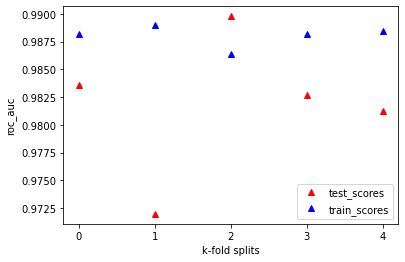

In [33]:
logisticrgr_cv_results = cross_validate(
    LogisticRegression(solver='saga', class_weight={0:0.60, 1:3.0}, max_iter=1000, random_state=42, multi_class='ovr'),
    X=X_train,
    y=y_train,
    scoring='roc_auc',
    cv=outer_cv,
    return_estimator=True,
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

fig, ax = plt.subplots()
ax.plot(logisticrgr_cv_results['test_score'], 'r^', label='test_scores')
ax.plot(logisticrgr_cv_results['train_score'], 'b^', label='train_scores')
ax.set_xlabel('k-fold splits')
ax.set_ylabel('roc_auc')
ax.set_xticks(range(5))
ax.legend()
ax.set_title('Fig 1. Comparing training and test scores for logistic regression');

### 7.2 Linear Discriminant Analysis

In [24]:
lda_params = [
    {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': (None, 'auto',0.001, 0.1, 0.5, 0.9)
    },
    
    {
        'solver': ['svd']
    }
]

lda = GridSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_grid=lda_params,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    n_jobs=-1
)

lda_cv_results = cross_validate(
                        estimator=lda,
                        X=X_train,
                        y=y_train,
                        scoring='roc_auc',
                        cv=outer_cv,
                        return_estimator=True,
                        verbose=10
)

lda_gridsearch_results = [pd.DataFrame(est.cv_results_) for est in lda_cv_results['estimator']]
reduce(lambda df1,df2: pd.concat([df1, df2]), lda_gridsearch_results).sort_values(by='rank_test_score').head(5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
Fitting 3 folds for each of 13 candidates, totalling 39 fits
[CV] END ......................................., score=0.982 total time=   6.0s
[CV] START .....................................................................
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END ......................................., score=0.975 total time=   4.0s
[CV] START .....................................................................
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] END ......................................., score=0.990 total time=   4.0s
[CV] START .....................................................................
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s


[CV] END ......................................., score=0.981 total time=   4.2s
[CV] START .....................................................................
Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.6s remaining:    0.0s


[CV] END ......................................., score=0.979 total time=   4.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.7s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_shrinkage,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.587638,0.027133,0.038951,0.009260,None,lsqr,"{'shrinkage': None, 'solver': 'lsqr'}",0.987874,0.974234,0.986064,0.982724,0.006049,1
1,0.592031,0.013652,0.034814,0.000857,None,eigen,"{'shrinkage': None, 'solver': 'eigen'}",0.981816,0.976340,0.992401,0.983519,0.006667,1
0,0.521520,0.013935,0.038917,0.001582,None,lsqr,"{'shrinkage': None, 'solver': 'lsqr'}",0.981816,0.976340,0.992401,0.983519,0.006667,1
12,0.712186,0.032970,0.022452,0.004218,NaN,svd,{'solver': 'svd'},0.987874,0.974234,0.986064,0.982724,0.006049,1
1,0.597654,0.009298,0.033202,0.002379,None,eigen,"{'shrinkage': None, 'solver': 'eigen'}",0.979817,0.978767,0.973659,0.977414,0.002690,1


Therefore, we decide to choose `solver=eigen` and `shrinkage=None`. `eigen` is preferred to `lsqr` because `eigen` generalizes well, both on relatively easy and hard-to-learn splits.

#### 7.2.1 Overfitting underfitting check

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


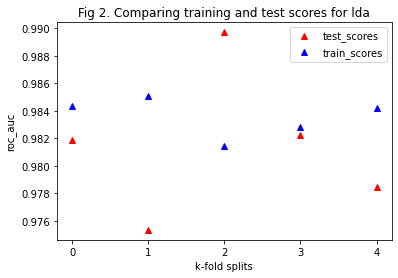

In [37]:
lda_cv_results = cross_validate(
    LinearDiscriminantAnalysis(solver='eigen'),
    X=X_train,
    y=y_train,
    scoring='roc_auc',
    cv=outer_cv,
    return_estimator=True,
    return_train_score=True,
    verbose=10,
    n_jobs=-1
)

fig, ax = plt.subplots()
ax.plot(lda_cv_results['test_score'], 'r^', label='test_scores')
ax.plot(lda_cv_results['train_score'], 'b^', label='train_scores')
ax.set_xlabel('k-fold splits')
ax.set_ylabel('roc_auc')
ax.set_xticks(range(5))
ax.legend()
ax.set_title('Fig 2. Comparing training and test scores for lda');

From both the figures 1 and 2 the following observations can be made -

<ol>
        <li>Linear discriminant analysis seems to be a better choice, in terms of generalization capacity. Besides, both have nearly equal mean test scores over the cv-splits.</li>
        <li>The third split in both cases show a greater train error than test. This indicates that there might be some bias in the linear models that can be improved with more flexible models.</li>
        <li>The second split in both cases show the largest drop from train to test. Hence there might be the presence of some outliers with high-leverage (because they have sufficient impact in the training and yet finally lead to bad generalization).</li>
</ol>
    
We use some non-linear models hence. Because the linear discriminant model worked very well, quadratic discriminant models might work pretty well too.

### 7.3 Quadratic discriminant analysis

In [54]:
qda_params = {
    'class_weight': class_weights_list
}

logistic_regr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='ovr', solver='saga', max_iter=1000),
    param_distributions=logistic_regr_params,
    n_iter=20,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    n_jobs=-1
)

logistic_cv_results = cross_validate(
                        estimator=logistic_regr,
                        X=X_train,
                        y=y_train,
                        scoring='roc_auc',
                        cv=outer_cv,
                        return_estimator=True,
                        verbose=10
)

489 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
